In [1]:
# Article 1

In [47]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import pandas as pd
import matplotlib.gridspec as gridspec 
import pickle
import nibabel as nib
from tvb.simulator.lab import *

In [112]:
sys.path.insert(0, '/Users/giovanni/Documents/GitHub/fufo/')
from src import analysis, simulation  # Import analysis for fcd and clustering

# IMPORT ALLEN 148

In [50]:
A148_con = connectivity.Connectivity.from_file('/Users/giovanni/Desktop/Neuro/tvb_codes/connectivity/Allen_148.zip')
nregions = len(A148_con.weights)     #number of regions
np.fill_diagonal(A148_con.weights, 0.)
A148_con.weights = A148_con.weights/np.max(A148_con.weights)
A148_SC = A148_con.weights

# Import region labels
path='/Users/giovanni/Desktop/Neuro/tvb_codes/connectivity/'
with open(path+'Allen_148/region_labels.txt') as f:
    content = f.readlines()  
# you may also want to remove whitespace characters like `\n` at the end of each line
ROIs = [ix.strip() for ix in content] 
#volsize=np.loadtxt(path+'/Allen_148/volsize.txt')

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


In [6]:
path_allen='/Users/giovanni/Desktop/Neuro/tvb_codes/connectivity/'
file_refs= nib.load(path_allen + 'Vol_148_Allen.nii')

A148= file_refs.get_fdata() 
A148=A148[:,:,:]

Vol_out=np.copy(A148)

file_refs= nib.load(path_allen + 'Template_rotated_Allen.nii')

Template= file_refs.get_fdata() 
Template=Template[:,:,:]

Template.shape

(114, 132, 80)

In [59]:
#Take the 74 labels (148 when considering right and left emispheres)
region_labels_148=[u'Frontal pole, cerebral cortex',u'Primary motor area',u'Primary somatosensory area, nose',u'Primary somatosensory area, barrel field',
                   u'Primary somatosensory area, lower limb',u'Primary somatosensory area, mouth',u'Primary somatosensory area, upper limb',u'Primary somatosensory area, trunk',
                   u'Supplemental somatosensory area',u'Primary auditory area',u'Anterolateral visual area',u'Anteromedial visual area',u'Lateral visual area',u'Primary visual area',
                   u'posteromedial visual area',u'Anterior cingulate area, dorsal part',u'Anterior cingulate area, ventral part',u'Infralimbic area',u'Orbital area, lateral part',
                   u'Orbital area, medial part',u'Agranular insular area, dorsal part',u'Agranular insular area, posterior part',u'Retrosplenial area, lateral agranular part',
                   u'Retrosplenial area, dorsal part',u'Retrosplenial area, ventral part',u'Temporal association areas',u'Ectorhinal area',u'Anterior olfactory nucleus',
                   u'Cortical amygdalar area, posterior part',u'Postpiriform transition area',u'Field CA1',u'Field CA3',u'Dentate gyrus',u'Entorhinal area, lateral part',
                   u'Parasubiculum',u'Subiculum',u'Endopiriform nucleus, dorsal part',u'Lateral amygdalar nucleus',u'Basolateral amygdalar nucleus',u'Basomedial amygdalar nucleus',
                   u'Caudoputamen',u'Nucleus accumbens',u'Lateral septal nucleus, rostral (rostroventral) part',u'Substantia innominata',u'Ventral anterior-lateral complex of the thalamus',
                   u'Ventral medial nucleus of the thalamus',u'Medial geniculate complex',u'Dorsal part of the lateral geniculate complex',u'Lateral posterior nucleus of the thalamus',
                   u'Posterior complex of the thalamus',u'Lateral dorsal nucleus of thalamus',u'Mediodorsal nucleus of thalamus',u'Reticular nucleus of the thalamus',u'Anterior hypothalamic nucleus',
                   u'Lateral hypothalamic area',u'Inferior colliculus',u'Midbrain reticular nucleus',u'Superior colliculus, motor related',u'Anterior pretectal nucleus',
                   u'Principal sensory nucleus of the trigeminal',u'Pontine reticular nucleus',u'Ventral cochlear nucleus',u'Nucleus of the solitary tract',
                   u'Spinal nucleus of the trigeminal, caudal part',u'Intermediate reticular nucleus',u'Medullary reticular nucleus',u'Medial vestibular nucleus',
                   u'Central lobule',u'Culmen',u'Folium-tuber vermis (VII)',u'Ansiform lobule',u'Paramedian lobule',u'Paraflocculus',u'Interposed nucleus']

# Import all Allen experiments

In [53]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

# The manifest file is a simple JSON file that keeps track of all of
# the data that has already been downloaded onto the hard drives.
# If you supply a relative path, it is assumed to be relative to your
# current working directory.
mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json')

# open up a list of all of the experiments
all_experiments = mcc.get_experiments(dataframe=True)
print("%d total experiments" % len(all_experiments))

2992 total experiments


# Get Allen indices associated to our 148 regions of interest

In [68]:
# grab the StructureTree instance
structure_tree = mcc.get_structure_tree()

# get info on structures of A148
structures = structure_tree.get_structures_by_name(region_labels_148)
df_A148=pd.DataFrame(structures)
df_A148

,acronym,graph_id,graph_order,id,name,structure_id_path,structure_set_ids,rgb_triplet
0,FRP,1,6,184,"Frontal pole, cerebral cortex","[997, 8, 567, 688, 695, 315, 184]","[3, 112905828, 688152357, 691663206, 687527945...","[38, 143, 69]"
1,MOp,1,18,985,Primary motor area,"[997, 8, 567, 688, 695, 315, 500, 985]","[112905828, 688152357, 691663206, 687527945, 1...","[31, 157, 90]"
2,SSp-n,1,44,353,"Primary somatosensory area, nose","[997, 8, 567, 688, 695, 315, 453, 322, 353]","[112905828, 688152357, 691663206, 687527945, 1...","[24, 128, 100]"
3,SSp-bfd,1,51,329,"Primary somatosensory area, barrel field","[997, 8, 567, 688, 695, 315, 453, 322, 329]","[112905828, 688152357, 691663206, 687527945, 1...","[24, 128, 100]"
4,SSp-ll,1,65,337,"Primary somatosensory area, lower limb","[997, 8, 567, 688, 695, 315, 453, 322, 337]","[112905828, 688152357, 691663206, 687527945, 1...","[24, 128, 100]"
...,...,...,...,...,...,...,...,...
69,FOTU,1,1050,944,Folium-tuber vermis (VII),"[997, 8, 512, 528, 645, 944]","[112905828, 691663206, 687527945, 12, 68815236...","[255, 252, 145]"
70,AN,1,1071,1017,Ansiform lobule,"[997, 8, 512, 528, 1073, 1017]","[112905828, 691663206, 687527945, 12, 68815236...","[255, 252, 145]"
71,PRM,1,1080,1025,Paramedian lobule,"[997, 8, 512, 528, 1073, 1025]","[112905828, 691663206, 687527945, 12, 68815236...","[255, 252, 145]"
72,PFL,1,1088,1041,Paraflocculus,"[997, 8, 512, 528, 1073, 1041]","[112905828, 691663206, 687527945, 12, 68815236...","[255, 252, 145]"


In [142]:
#structure_tree.get_structures_by_id([315])[0]['acronym']

'Isocortex'

In [71]:
#The associated ids
Allen_id_for_A148=np.asarray(df_A148['id'])
Allen_id_for_A148

array([ 184,  985,  353,  329,  337,  345,  369,  361,  378, 1002,  402,
        394,  409,  385,  533,   39,   48,   44,  723,  731,  104,  111,
        894,  879,  886,  541,  895,  159,  647,  566,  382,  463,  726,
        918,  843,  502,  952,  131,  295,  319,  672,   56,  258,  342,
        629,  685,  475,  170,  218, 1020,  155,  362,  262,   88,  194,
          4,  128,  294,  215,    7,  146,  101,  651,  429,  136,  395,
        202,  920,  928,  944, 1017, 1025, 1041,   91])

In [78]:
#In fact...

ID_Allen_A148={}

for i, order_i in enumerate(Allen_id_for_A148):
    ID_Allen_A148['%d'%order_i]=i
    print(i, str(structure_tree.get_structures_by_id([order_i])[0]['name']))

0 Frontal pole, cerebral cortex
1 Primary motor area
2 Primary somatosensory area, nose
3 Primary somatosensory area, barrel field
4 Primary somatosensory area, lower limb
5 Primary somatosensory area, mouth
6 Primary somatosensory area, upper limb
7 Primary somatosensory area, trunk
8 Supplemental somatosensory area
9 Primary auditory area
10 Anterolateral visual area
11 Anteromedial visual area
12 Lateral visual area
13 Primary visual area
14 posteromedial visual area
15 Anterior cingulate area, dorsal part
16 Anterior cingulate area, ventral part
17 Infralimbic area
18 Orbital area, lateral part
19 Orbital area, medial part
20 Agranular insular area, dorsal part
21 Agranular insular area, posterior part
22 Retrosplenial area, lateral agranular part
23 Retrosplenial area, dorsal part
24 Retrosplenial area, ventral part
25 Temporal association areas
26 Ectorhinal area
27 Anterior olfactory nucleus
28 Cortical amygdalar area, posterior part
29 Postpiriform transition area
30 Field CA1


# Import Grandjean Atlas and extract all the Allen indices of the regions

In [72]:
path='/Users/giovanni/Desktop/Neuro/Grandjean_mouse_fMRI/'
df_Grandj=pd.read_csv(path+'atlas.tsv',sep="\t")
df_Grandj

,id,Allen.id,parent.id,acronym,name,hex,level,hemisphere,n.vox
0,1,184,315,FRP,"Frontal pole, cerebral cortex",268F45,8,right,58
1,2,985,500,MOp,Primary motor area,1F9D5A,8,right,719
2,3,993,500,MOs,Secondary motor area,1F9D5A,8,right,802
3,4,353,322,SSp-n,"Primary somatosensory area, nose",188064,9,right,193
4,5,329,322,SSp-bfd,"Primary somatosensory area, barrel field",188064,9,right,377
...,...,...,...,...,...,...,...,...,...
599,600,1049,1073,FL,Flocculus,FFFC91,8,left,87
600,601,989,519,FN,Fastigial nucleus,FFFDBC,8,left,33
601,602,91,519,IP,Interposed nucleus,FFFDBC,8,left,60
602,603,846,519,DN,Dentate nucleus,FFFDBC,8,left,21


In [73]:
#The associated ids
Allen_id_for_Grandj=np.asarray(df_Grandj['Allen.id'])
Grandj_id=np.asarray(df_Grandj['id'])

In [77]:
Allen_id_for_Grandj

array([      184,       985,       993,       353,       329,       337,
             345,       369,       361, 182305689,       378,      1057,
             677,      1011,      1002,      1027,      1018,       669,
             402,       394,       409,       385,       425,       533,
       312782574, 312782628,        31,       972,        44,       714,
              95,       254,        22, 312782546,       417,       541,
             922,       895,       507,       151,       159,       589,
             814,       961,       619,       639,       647,       788,
             566,       382,       423,       463,       726,       982,
              19,       909,       843,      1037,      1084,       502,
       589508447,       583,       952,       966,       131,       303,
             311,       451,       319,       780,       672,        56,
             998,       754, 549009199,       242,       310,       333,
              23,       292,       536,      1105, 

In [81]:
Allen_id_for_A148

array([ 184,  985,  353,  329,  337,  345,  369,  361,  378, 1002,  402,
        394,  409,  385,  533,   39,   48,   44,  723,  731,  104,  111,
        894,  879,  886,  541,  895,  159,  647,  566,  382,  463,  726,
        918,  843,  502,  952,  131,  295,  319,  672,   56,  258,  342,
        629,  685,  475,  170,  218, 1020,  155,  362,  262,   88,  194,
          4,  128,  294,  215,    7,  146,  101,  651,  429,  136,  395,
        202,  920,  928,  944, 1017, 1025, 1041,   91])

# Take the areas of A148 which are the same as Grandjean and associate them to the Grandjean index

In [101]:
ID_A148_to_Grandj_reduced={}
Missing=[]
for io, o in enumerate(Allen_id_for_A148):
    if o in Allen_id_for_Grandj:
        ID_A148_to_Grandj_reduced['%d'%ID_Allen_A148['%d'%o]]=np.where(Allen_id_for_Grandj==o)[0][0]               #Right regions
        ID_A148_to_Grandj_reduced['%d'%(ID_Allen_A148['%d'%o]+74)]=np.where(Allen_id_for_Grandj==o)[0][1]            #Left regions
    else:
        Missing.append(o)

In [102]:
#There are missing regions i.e., regions in the 104 which do not appear directly 
Missing_regions={}
for im, m in enumerate(Missing):
    Missing_regions['%d'%m]=str(region_labels_148[np.where(np.asarray(Allen_id_for_A148)==m)[0][0]])
Missing_regions

{'39': 'Anterior cingulate area, dorsal part',
 '48': 'Anterior cingulate area, ventral part',
 '723': 'Orbital area, lateral part',
 '731': 'Orbital area, medial part',
 '104': 'Agranular insular area, dorsal part',
 '111': 'Agranular insular area, posterior part',
 '894': 'Retrosplenial area, lateral agranular part',
 '879': 'Retrosplenial area, dorsal part',
 '886': 'Retrosplenial area, ventral part',
 '918': 'Entorhinal area, lateral part',
 '295': 'Basolateral amygdalar nucleus',
 '258': 'Lateral septal nucleus, rostral (rostroventral) part'}

In [94]:
# Add Grandj regions by hand
Grandj_name=np.asarray(df_Grandj['name'])
Grandj_name

array(['Frontal pole, cerebral cortex', 'Primary motor area',
       'Secondary motor area', 'Primary somatosensory area, nose',
       'Primary somatosensory area, barrel field',
       'Primary somatosensory area, lower limb',
       'Primary somatosensory area, mouth',
       'Primary somatosensory area, upper limb',
       'Primary somatosensory area, trunk',
       'Primary somatosensory area, unassigned',
       'Supplemental somatosensory area', 'Gustatory areas',
       'Visceral area', 'Dorsal auditory area', 'Primary auditory area',
       'Posterior auditory area', 'Ventral auditory area', 'Visual areas',
       'Anterolateral visual area', 'Anteromedial visual area',
       'Lateral visual area', 'Primary visual area',
       'Posterolateral visual area', 'posteromedial visual area',
       'Laterointermediate area', 'Postrhinal area',
       'Anterior cingulate area', 'Prelimbic area', 'Infralimbic area',
       'Orbital area', 'Agranular insular area', 'Retrosplenial area

In [95]:
np.where(Grandj_name=='Retrosplenial area')[0]

array([ 31, 333])

In [98]:
ID_Allen_A148['39']

15

In [105]:
#Add Agranular insular area (I need to define regions 104 and 111 as the same)
ID_A148_to_Grandj_reduced['%d'%ID_Allen_A148['104']]=np.where(Grandj_name=='Agranular insular area')[0][0]
ID_A148_to_Grandj_reduced['%d'%(ID_Allen_A148['104']+74)]=np.where(Grandj_name=='Agranular insular area')[0][1]
ID_A148_to_Grandj_reduced['%d'%ID_Allen_A148['111']]=np.where(Grandj_name=='Agranular insular area')[0][0]
ID_A148_to_Grandj_reduced['%d'%(ID_Allen_A148['111']+74)]=np.where(Grandj_name=='Agranular insular area')[0][1]
#Add Orbital area (I need to define regions 723 and 731 as the same)
ID_A148_to_Grandj_reduced['%d'%ID_Allen_A148['723']]=np.where(Grandj_name=='Orbital area')[0][0]
ID_A148_to_Grandj_reduced['%d'%(ID_Allen_A148['723']+74)]=np.where(Grandj_name=='Orbital area')[0][1]
ID_A148_to_Grandj_reduced['%d'%ID_Allen_A148['731']]=np.where(Grandj_name=='Orbital area')[0][0]
ID_A148_to_Grandj_reduced['%d'%(ID_Allen_A148['731']+74)]=np.where(Grandj_name=='Orbital area')[0][1]
#Add Anterior cingulate area (I need to define regions 39 and 48 as the same)
ID_A148_to_Grandj_reduced['%d'%ID_Allen_A148['39']]=np.where(Grandj_name=='Anterior cingulate area')[0][0]
ID_A148_to_Grandj_reduced['%d'%(ID_Allen_A148['39']+74)]=np.where(Grandj_name=='Anterior cingulate area')[0][1]
ID_A148_to_Grandj_reduced['%d'%ID_Allen_A148['48']]=np.where(Grandj_name=='Anterior cingulate area')[0][0]
ID_A148_to_Grandj_reduced['%d'%(ID_Allen_A148['48']+74)]=np.where(Grandj_name=='Anterior cingulate area')[0][1]
#Add Retrosplenial area (I need to define regions 879 and 886 as the same)
ID_A148_to_Grandj_reduced['%d'%ID_Allen_A148['879']]=np.where(Grandj_name=='Retrosplenial area')[0][0]
ID_A148_to_Grandj_reduced['%d'%(ID_Allen_A148['879']+74)]=np.where(Grandj_name=='Retrosplenial area')[0][1]
ID_A148_to_Grandj_reduced['%d'%ID_Allen_A148['886']]=np.where(Grandj_name=='Retrosplenial area')[0][0]
ID_A148_to_Grandj_reduced['%d'%(ID_Allen_A148['886']+74)]=np.where(Grandj_name=='Retrosplenial area')[0][1]
ID_A148_to_Grandj_reduced['%d'%ID_Allen_A148['894']]=np.where(Grandj_name=='Retrosplenial area')[0][0]
ID_A148_to_Grandj_reduced['%d'%(ID_Allen_A148['894']+74)]=np.where(Grandj_name=='Retrosplenial area')[0][1]
#Add Entorhinal area 
ID_A148_to_Grandj_reduced['%d'%ID_Allen_A148['918']]=np.where(Grandj_name=='Entorhinal area')[0][0]
ID_A148_to_Grandj_reduced['%d'%(ID_Allen_A148['918']+74)]=np.where(Grandj_name=='Entorhinal area')[0][1]
#Add Entorhinal area
ID_A148_to_Grandj_reduced['%d'%ID_Allen_A148['295']]=np.where(Grandj_name=='Basolateral amygdalar nucleus, posterior part')[0][0]
ID_A148_to_Grandj_reduced['%d'%(ID_Allen_A148['295']+74)]=np.where(Grandj_name=='Basolateral amygdalar nucleus, posterior part')[0][1]
#Add Entorhinal area 
ID_A148_to_Grandj_reduced['%d'%ID_Allen_A148['258']]=np.where(Grandj_name=='Lateral septal nucleus')[0][0]
ID_A148_to_Grandj_reduced['%d'%(ID_Allen_A148['258']+74)]=np.where(Grandj_name=='Lateral septal nucleus')[0][1]

In [106]:
len(ID_A148_to_Grandj_reduced.keys())

148

In [107]:
import pickle

# write python dict to a file
output = open('ID_A148_to_Grandj_reduced.pkl', 'wb')
pickle.dump(ID_A148_to_Grandj_reduced, output)
output.close()

# import pickle

# # read python dict back from the file
# pkl_file = open('ID_A148_to_Grandj_reduced.pkl', 'rb')
# ID_A148_to_Grandj_reduced = pickle.load(pkl_file)
# pkl_file.close()

# Import Grandjean fMRI dataset with 604 regions

In [46]:
path='/Users/giovanni/Desktop/Neuro/Grandjean_mouse_fMRI/timeseries/'

bold={}
nsub=50
for ii, i in enumerate(range(1,nsub+1)):
    bold['%d'%(ii+1)]=np.loadtxt(path+'%04d.txt'%i)

# for each subject we get a bold time series with 604 ROIs and 500 time points
bold['1'].shape

(500, 604)

# Plot Grandjean BOLD only in voxels which are considered by A148

In [109]:
Bold={}
for j in range(1,nsub+1):
    bd=np.zeros((500,nregions))
    for i in range(nregions):
        bd[:,i]=bold['%d'%j][:,ID_A148_to_Grandj_reduced['%d'%i]]
    Bold['%d'%j]=bd

In [110]:
subject=45

In [146]:
Bold['%d'%subject].shape

(500, 148)

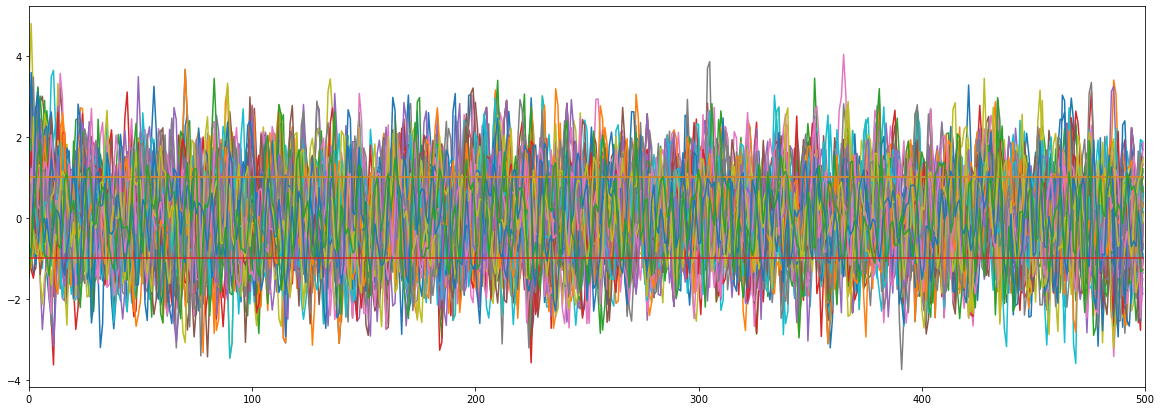

In [147]:
plt.figure(figsize=(20,7))
plt.plot(stats.zscore(Bold['%d'%subject])[:,:74])
plt.xlim(0,500)
plt.show()

In [115]:
Edges=analysis.go_edge(Bold['%d'%subject])
eFCD=np.corrcoef(Edges)

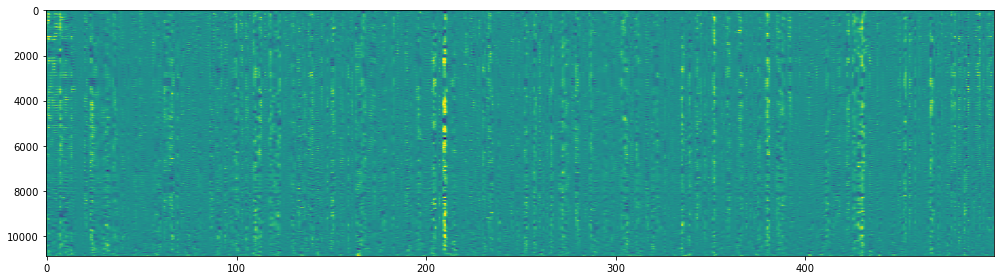

In [117]:
plt.figure(figsize=(14,4))
plt.imshow(Edges[:,:].T,aspect='auto', cmap='viridis',vmin=-2.5,vmax=2.5)
#plt.colorbar()
plt.tight_layout()
plt.show()

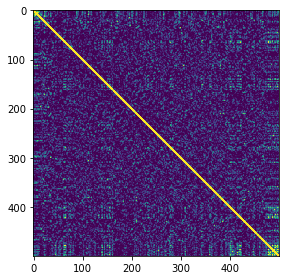

In [151]:
plt.figure(figsize=(14,4))
plt.imshow(eFCD[:,:],vmin=0.,vmax=0.15)
#plt.colorbar()
plt.tight_layout()
plt.show()

In [119]:
np.argsort(np.var(Bold['%d'%subject],axis=0))

array([143, 139, 137,  71,  69,  65,  63, 145, 136,  73,  62, 147, 138,
       144, 135, 146,  64,  72,  70, 142,   0,  66,  68, 140,  61,  74,
       141, 133, 114, 107,  75,  20,  21,  94,  95,  27,   1, 104, 102,
       101,  82,  98,  97,  96,  40,  24,  23,  22,  67,  18,  19,  93,
        92,  33, 109,  30, 105,  28, 106,  87,  41, 115,  43,   8,  32,
       110,  79,   5, 117,  15,  16,  77,  31,  89,  90,  80, 130, 126,
        35,  99,   3, 116,   2,  25, 113, 131,  42,  36,  13,   6,  57,
        56, 129, 103, 100,  52, 128,   9, 134,  76, 108,  55,  60,  86,
        78,  39,  54,  81,  29,  83,  26,   7,  51, 112,  17, 125, 132,
         4,  88, 124,  44, 119, 118,  91,  59,  84, 122,  48, 127,  49,
        12,  50,  45, 111,  58, 123,  34,  47, 120,  14,  53,  85,  46,
        38,  10, 121,  37,  11])

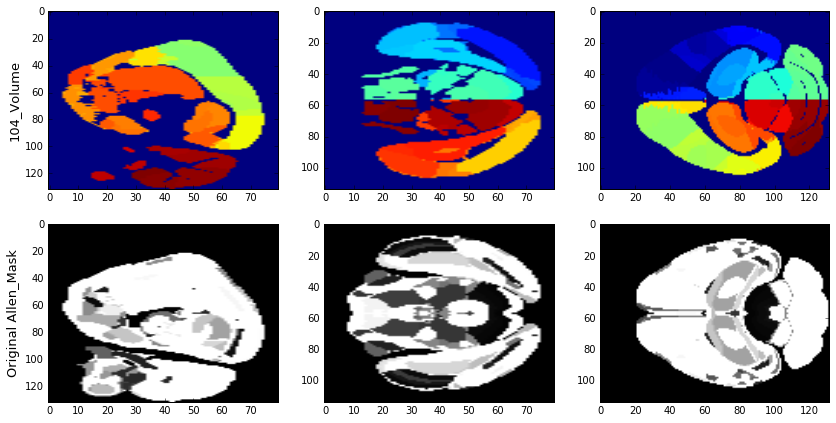

In [304]:
#Rotate detailed Vol_ in the 104Roisvolume direction

depth=1.4
plt.figure(figsize=(14,7))
slice_idx=int(np.shape(volume)[0]/depth);slice_idy=int(np.shape(volume)[1]/depth);slice_idz=int(np.shape(volume)[2]/depth)
plt.subplot(231);plt.imshow(volume[slice_idx,:,:],aspect='auto');plt.ylabel('104_Volume',fontsize=13)
plt.subplot(232);plt.imshow(volume[:,slice_idy,:],aspect='auto')
plt.subplot(233);plt.imshow(volume[:,:,slice_idz],aspect='auto')

Vol_rot=np.swapaxes(np.swapaxes(Vol_,0,1),0,2)
Vol_rot=np.flip(Vol_rot,2)
#Vol_rot=np.flip(Vol_rot,1)
#Vol_rot=np.flip(Vol_rot,0)
slice_idx=int(np.shape(Vol_rot)[0]/depth);slice_idy=int(np.shape(Vol_rot)[1]/depth);slice_idz=int(np.shape(Vol_rot)[2]/depth)
plt.subplot(234);plt.imshow(Vol_rot[slice_idx,:,:],aspect='auto',cmap='gray',vmin=0,vmax=600);plt.ylabel('Original Allen_Mask',fontsize=13)
plt.subplot(235);plt.imshow(Vol_rot[:,slice_idy,:],aspect='auto',cmap='gray',vmin=0,vmax=600)
plt.subplot(236);plt.imshow(Vol_rot[:,:,slice_idz],aspect='auto',cmap='gray',vmin=0,vmax=600)

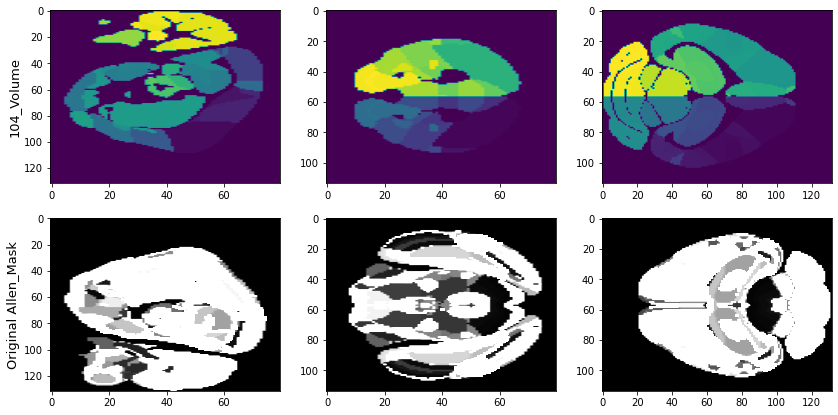

In [33]:
#Rotate detailed Vol_ in the 104Roisvolume direction

depth=1.4
plt.figure(figsize=(14,7))
slice_idx=int(np.shape(Vol_out)[0]/depth);slice_idy=int(np.shape(Vol_out)[1]/depth);slice_idz=int(np.shape(Vol_out)[2]/depth)
plt.subplot(231);plt.imshow(Vol_out[slice_idx,:,:],aspect='auto');plt.ylabel('104_Volume',fontsize=13)
plt.subplot(232);plt.imshow(Vol_out[:,slice_idy,:],aspect='auto')
plt.subplot(233);plt.imshow(Vol_out[:,:,slice_idz],aspect='auto')

Vol_rot=np.swapaxes(np.swapaxes(Vol_,0,1),0,2)
Vol_rot=np.flip(Vol_rot,2)
#Vol_rot=np.flip(Vol_rot,1)
#Vol_rot=np.flip(Vol_rot,0)
slice_idx=int(np.shape(Vol_rot)[0]/depth);slice_idy=int(np.shape(Vol_rot)[1]/depth);slice_idz=int(np.shape(Vol_rot)[2]/depth)
plt.subplot(234);plt.imshow(Vol_rot[slice_idx,:,:],aspect='auto',cmap='gray',vmin=0,vmax=600);plt.ylabel('Original Allen_Mask',fontsize=13)
plt.subplot(235);plt.imshow(Vol_rot[:,slice_idy,:],aspect='auto',cmap='gray',vmin=0,vmax=600)
plt.subplot(236);plt.imshow(Vol_rot[:,:,slice_idz],aspect='auto',cmap='gray',vmin=0,vmax=600)